In [1]:
import numpy as np 
import pandas as pd 
from keras import layers
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from os import listdir, makedirs
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers, regularizers
from keras import losses

Using TensorFlow backend.


In [2]:
RESOLUTION = 197
BATCH_SIZE = 20

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        "../input/state-farm-distracted-driver-detection/train/",
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training")

val_generator = val_datagen.flow_from_directory(
        "../input/state-farm-distracted-driver-detection/train/",
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation")

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


In [4]:
path = "../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
conv_base = InceptionResNetV2(include_top=False, input_shape=(RESOLUTION, RESOLUTION, 3), weights=path)

In [5]:
def inceptionv2_pretrained_model(model_inception, dropout_=False, regularizer_=False, regularizer_weight=0.001):
    model = Sequential()
    model.add(model_inception)
    model.add(Flatten())
    if dropout_:
        model.add(Dropout(0.5))
    if regularizer_:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss=losses.poisson, optimizer=optimizers.Nadam(lr=1e-5), metrics=['acc'])

    return model

In [6]:
model = inceptionv2_pretrained_model(conv_base, dropout_=False, regularizer_=False, regularizer_weight=0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6291712   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 60,631,018
Trainable params: 60,570,474
Non-trainable params: 60,544
_________________________________________________________________


In [7]:
N_TRAIN = 15702
N_VAL = 6722
history = model.fit_generator(
        train_generator,
        steps_per_epoch=(N_TRAIN // BATCH_SIZE),
        epochs=10,
        validation_data=val_generator,
        validation_steps=(N_VAL // BATCH_SIZE) 
    )

Epoch 1/10
785/785 [==============================] - 995s 1s/step - loss: 0.1741 - acc: 0.7883 - val_loss: 0.1135 - val_acc: 0.9717
Epoch 2/10
785/785 [==============================] - 926s 1s/step - loss: 0.1057 - acc: 0.9894 - val_loss: 0.1061 - val_acc: 0.9864
Epoch 3/10
785/785 [==============================] - 920s 1s/step - loss: 0.1018 - acc: 0.9969 - val_loss: 0.1035 - val_acc: 0.9912
Epoch 4/10
785/785 [==============================] - 920s 1s/step - loss: 0.1014 - acc: 0.9980 - val_loss: 0.1030 - val_acc: 0.9930
Epoch 5/10
785/785 [==============================] - 921s 1s/step - loss: 0.1007 - acc: 0.9982 - val_loss: 0.1045 - val_acc: 0.9858
Epoch 6/10
785/785 [==============================] - 920s 1s/step - loss: 0.1005 - acc: 0.9990 - val_loss: 0.1022 - val_acc: 0.9948
Epoch 7/10
785/785 [==============================] - 922s 1s/step - loss: 0.1002 - acc: 0.9999 - val_loss: 0.1026 - val_acc: 0.9927
Epoch 8/10
785/785 [==============================] - 923s 1s/step - 

In [8]:
history.params

{'epochs': 10,
 'steps': 785,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

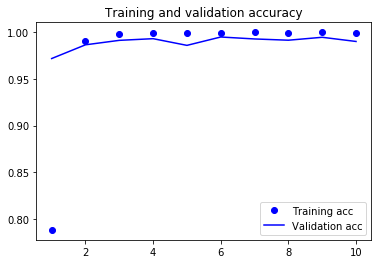

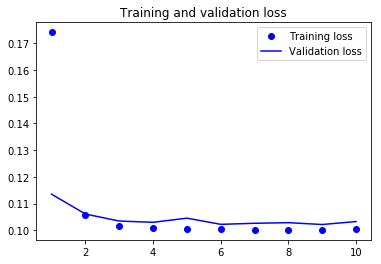

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')